# Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. 

Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. 

Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, DateFormatter
import numpy as np

Import Data

In [39]:
logins = pd.read_json('data/logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [40]:
# Check data type
logins.dtypes

login_time    datetime64[ns]
dtype: object

In [41]:
# Check shape of data
logins.shape

(93142, 1)

### Aggregate Logins based on 15 minute Intervals

In [42]:
# Set timestamps as index and add a count for each login occurence
login_count = logins.set_index('login_time')
login_count['count'] = 1

# Downsample the series into 15-minute bins and sum the values of the timestamps
# falling into a bin.
login_count = login_count.resample('15T').sum()
login_count.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


### Visualize Time Series

* What are some important features of the demand?
* Are there any data quality issues?

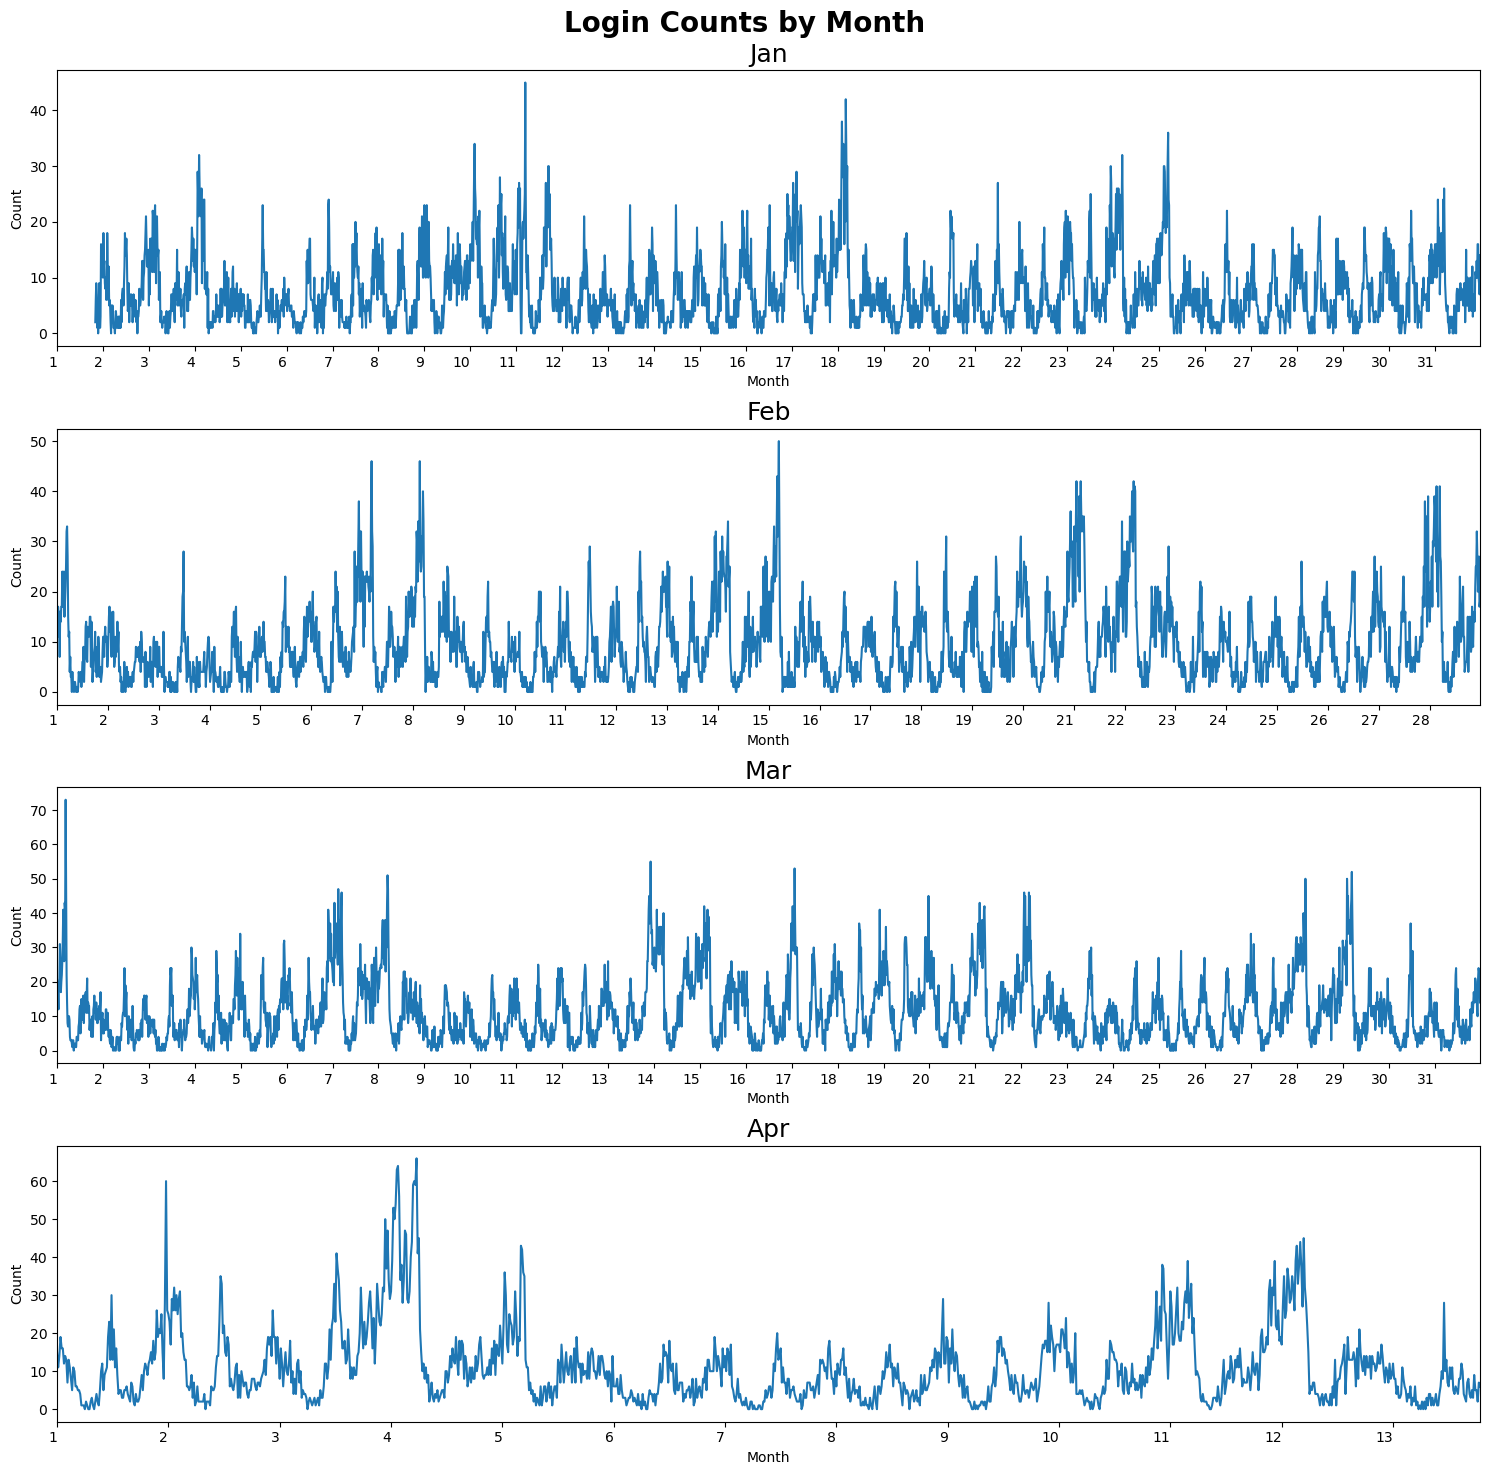

In [43]:

# Visualize Login Counts per Month based on 15 min Intervals
fig, axes = plt.subplots(4, 1, figsize=(15, 15))

days = ['01', '02', '03', '04']
months = ['Jan', 'Feb', 'Mar', 'Apr']

# Plot login counts for each month for better clarity
for ax, day, month in zip(axes, days, months):
    login_data = login_count.loc[f'1970-{day}']
    ax = login_data.plot(ax=ax, kind='line', legend=False, ylabel='Count', xlabel='Month')

    # Label Plots
    ax.set_title(month, fontdict=({
        'fontsize': 18,
    }))

    # Set x-ticks for every day of the month
    days_of_month = pd.date_range(start=login_data.index[0].replace(hour=0, minute=0, second=0),
                              end=login_data.index[-1].replace(hour=23, minute=45, second=0), freq='D')
    ax.set_xticks(days_of_month)

    # Format x-axis labels as day of the month
    ax.set_xticklabels(days_of_month.day, rotation=0, ha='right')


# Figure Edits
fig.tight_layout()
fig.suptitle('Login Counts by Month', fontweight='bold', fontsize=20)
plt.subplots_adjust(top=0.94)

plt.show()

### Get Descriptive Statistics by Month

In [44]:
# Get summary statistics for Month
login_count.groupby(pd.Grouper(freq='M')).describe()

count                                                
             count       mean       std  min  25%  50%   75%   max
login_time                                                        
1970-01-31  2896.0   7.333909  6.099863  0.0  3.0  6.0  10.0  45.0
1970-02-28  2688.0   9.178943  7.796656  0.0  3.0  7.0  13.0  50.0
1970-03-31  2976.0  11.331653  9.335820  0.0  4.0  9.0  16.0  73.0
1970-04-30  1228.0  10.999186  9.969840  0.0  4.0  8.0  15.0  66.0

### Visualize Total Count by Month

In [45]:
def annotate_plot(data, axis, x=0.1):
    '''
    Annotates the bars for the barplot with the counts at the top of the bars, 
    along with a horizontal line displaying the mean count.
    '''
    # Annotate bars with counts
    for p in axis.patches:
        axis.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='top', xytext=(0, 10), textcoords='offset points')

    # Set Mean line
    mean = int(data.mean(numeric_only=True))
    ax.axhline(mean, color='red', linewidth=0.75)
    ax.annotate(f'Mean Count: {mean}', xy=(x, mean), va='bottom', color='red')

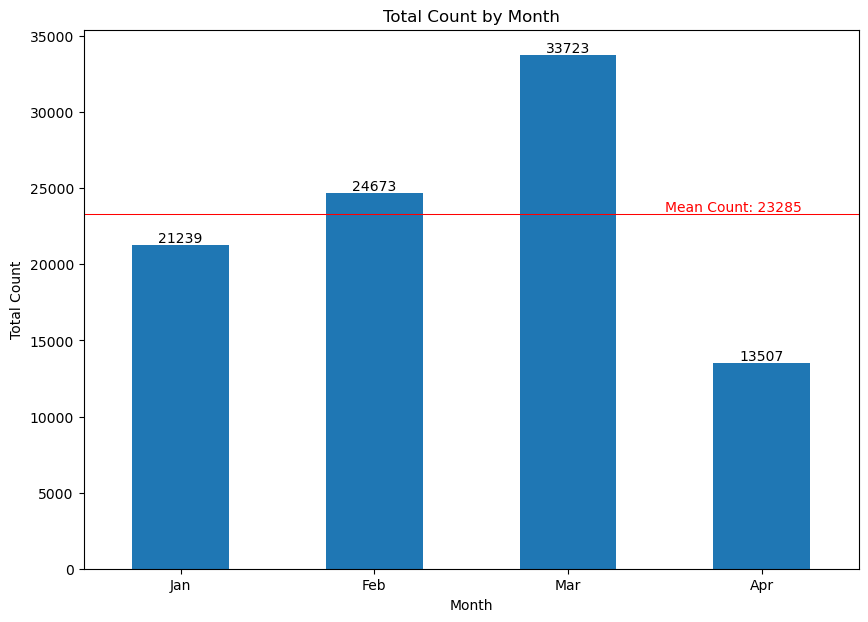

In [46]:
# Visualize total login count by Month
total_count_by_month = login_count.groupby(pd.Grouper(freq='M')).sum()
total_count_by_month['month'] = ['Jan', 'Feb', 'Mar', 'Apr']
ax = total_count_by_month.plot(kind='bar', x='month', y='count', rot=0, figsize=(10,7),
                               ylabel='Total Count', xlabel='Month',
                               title='Total Count by Month', legend=False)

# Annotate labels at the top of the bars
annotate_plot(total_count_by_month, ax, x=2.5)

# Show the plot
plt.show()


From plotting the login counts by month and getting descriptive statistics, a few observations can be noted:
1. The month of April only has data up to the 13th of the month   
2. There was an upward trend in login counts going from Jan-Mar, and with more data for the month of April, the trend may have continued.  
3. The median daily logins also showed an upward trend from Jan-Mar going from 6 to 7 to 9 for respective months.  
4. The max daily logins also exhibited an upward trend going from 45 to 50 to 73 for the first 3 months. 
5. The months of February and March had above average login counts when grouped by Month

### Visualize Weekly Trends

In [48]:
# Get Weekly Login Counts
logins_by_week = logins.set_index('login_time')
logins_by_week['count'] = 1
weekly_count = logins_by_week.groupby(pd.Grouper(freq='W')).sum()
weekly_count

,count
login_time,
1970-01-04,2374
1970-01-11,5217
1970-01-18,5023
1970-01-25,4751
1970-02-01,4744
1970-02-08,5572
1970-02-15,5915
1970-02-22,7035
1970-03-01,6554


In [49]:
# Get xtick labels
import re
from itertools import chain

pattern = r"\d{4}-(\d{2}-\d{2})"
weeks = []

# Find only month-day patterns representing each week
for i in weekly_count.index:
    weeks.append(re.findall(pattern, str(i)))

# Flatten list of lists
weeks = list(chain(*weeks))

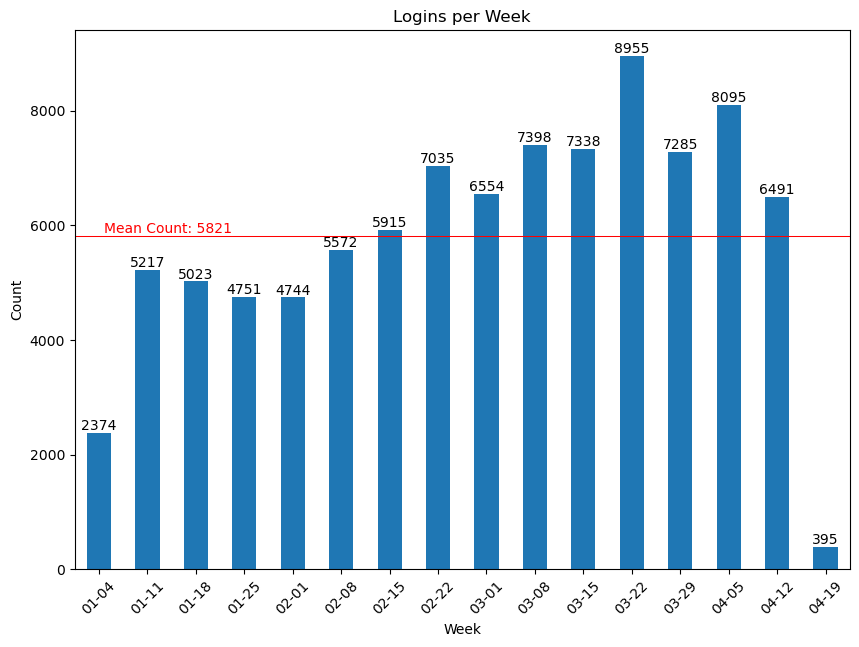

In [50]:
# Plot weekly logins
ax = weekly_count.plot(figsize=(10, 7), rot=45, kind='bar', legend=False)

# Label plot
ax.set_title('Logins per Week')
ax.set_ylabel('Count')
ax.set_xlabel('Week')
ax.set_xticklabels(weeks)

# Annotate labels at the top of the bars
annotate_plot(weekly_count, ax)

plt.show()

As noted before, the upward trend also persisted strongly week to week, peaking the week of `03-22`.  

Since the last recorded date was `04-13`, the count for the week of `04-19` is not entirely accurate and must be ignored.

### Visualize Logins by Days of the Week

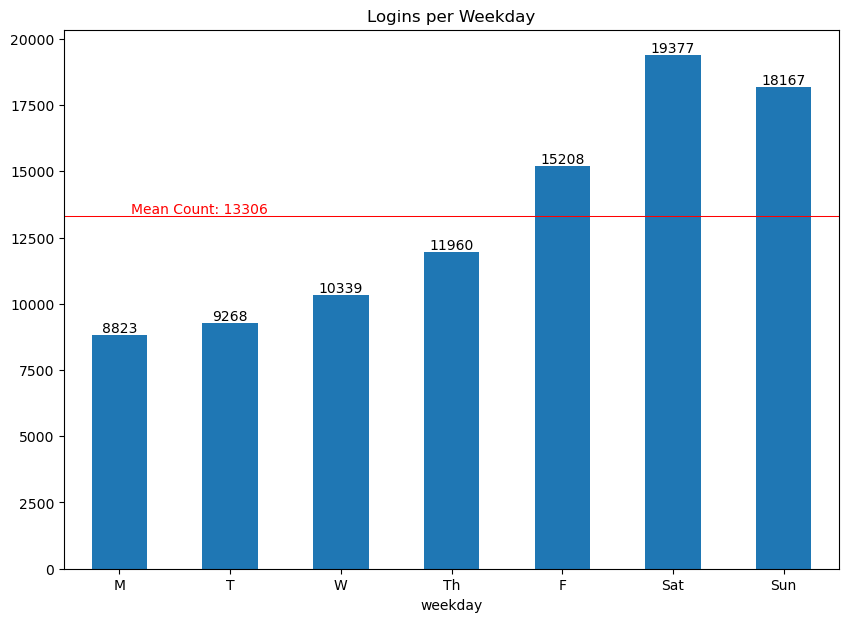

In [51]:
by_weekday = logins.copy(True)

# Add column mapping login timestamp to day of the week
by_weekday['weekday'] = logins['login_time'].dt.day_of_week

# Plot by day of the Week
counts = by_weekday.groupby('weekday').count()
ax = counts.plot(kind='bar', rot=0, figsize=(10, 7), legend=False, title='Logins per Weekday')
ax.set_xticklabels(['M', 'T', 'W', 'Th', 'F', 'Sat', 'Sun'])

# Annotate labels at the top of the bars
annotate_plot(counts, ax)

plt.show()

From the plot, it appears that there is daily trend where logins increase steadily from Monday to Friday, peaking on Saturday before dipping on Sunday.  

The weekend (Fri-Sun) had above average login times.